In [1]:
# Simple Fashion Classifier via using MNIST and MamaNet1 (Garment Classification)
"""
This module is developed by Suanfamama.

Authors:
- Wei Jiang (wei@suanfamama.com)
- Mama Xiao (mama.xiao@suanfamama.com)

Reference:
- Training with PyTorch
- https://pytorch.org/tutorials/beginner/introyt/trainingyt.html?highlight=nn%20crossentropyloss
"""

'\nThis module is developed by Suanfamama.\n\nAuthors:\n- Wei Jiang (wei@suanfamama.com)\n- Mama Xiao (mama.xiao@suanfamama.com)\n\nReference:\n- Training with PyTorch\n- https://pytorch.org/tutorials/beginner/introyt/trainingyt.html?highlight=nn%20crossentropyloss\n'

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

# Class labels
classes = ('T-shirt', 'Trouser裤子', 'Pullover套衫', 'Dress裙子', 'Coat大衣',
        'Sandal拖鞋', 'Shirt衬衫', 'Sneaker运动鞋', 'Bag包', 'Ankle Boot靴子')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

100%|██████████| 26421880/26421880 [00:01<00:00, 13321314.05it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 263377.68it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4953209.61it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 9400207.66it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Training set has 60000 instances
Validation set has 10000 instances


Sneaker运动鞋  Sneaker运动鞋  Sandal拖鞋  T-shirt


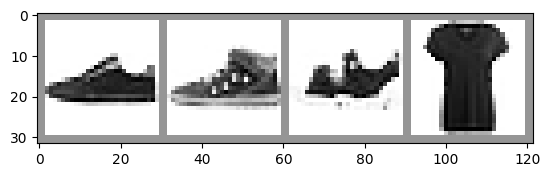

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

In [4]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class MamaNet1(nn.Module):
    def __init__(self):
        super(MamaNet1, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = MamaNet1()

In [5]:
loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.4230, 0.3972, 0.8051, 0.4679, 0.4382, 0.6822, 0.7099, 0.9884, 0.5833,
         0.0608],
        [0.6235, 0.9824, 0.4759, 0.6801, 0.7107, 0.1589, 0.6276, 0.2884, 0.7592,
         0.6102],
        [0.6150, 0.4114, 0.2811, 0.6157, 0.0556, 0.6120, 0.5074, 0.4930, 0.5088,
         0.5147],
        [0.4569, 0.2696, 0.2447, 0.9312, 0.3606, 0.7941, 0.4098, 0.6694, 0.0218,
         0.6717]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.39064884185791


In [8]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [9]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [10]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 1.9888854761421682
  batch 2000 loss: 0.8654370718672871
  batch 3000 loss: 0.7181394039057195
  batch 4000 loss: 0.6422588613159024
  batch 5000 loss: 0.5818008952420205
  batch 6000 loss: 0.5630869365353137
  batch 7000 loss: 0.5275045417854562
  batch 8000 loss: 0.5414762285382021
  batch 9000 loss: 0.4943688377077924
  batch 10000 loss: 0.48740198504796717
  batch 11000 loss: 0.4805944852523971
  batch 12000 loss: 0.48267784214997667
  batch 13000 loss: 0.4646663193977438
  batch 14000 loss: 0.4641702099972754
  batch 15000 loss: 0.4419606843144866
LOSS train 0.4419606843144866 valid 0.4533537030220032
EPOCH 2:
  batch 1000 loss: 0.42158935276651754
  batch 2000 loss: 0.4308954105418816
  batch 3000 loss: 0.4230270767085603
  batch 4000 loss: 0.40136889451633034
  batch 5000 loss: 0.38238784450944513
  batch 6000 loss: 0.3794457781177771
  batch 7000 loss: 0.3819180873098085
  batch 8000 loss: 0.3866566767649201
  batch 9000 loss: 0.3755332744928892
  ba

In [11]:
    # Save the model checkpoint
    import os
    model_save_dir = "./"  # Directory to save the models
    model_path = os.path.join(model_save_dir, f'MamaNet1_Garment_Classification.pth')
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

Model saved to ./MamaNet1_Garment_Classification.pth


Predicted: T-shirt, Actual: T-shirt
Predicted: Sneaker运动鞋, Actual: Sneaker运动鞋
Predicted: Dress裙子, Actual: Dress裙子
Predicted: Coat大衣, Actual: Coat大衣
Predicted: Dress裙子, Actual: Dress裙子
Predicted: Coat大衣, Actual: Coat大衣


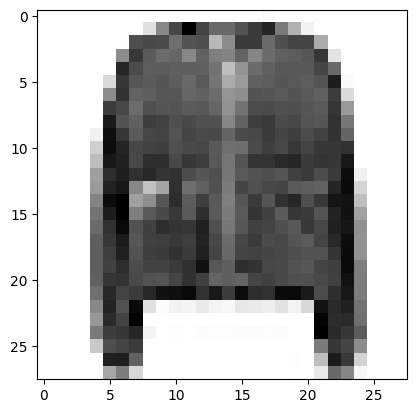

In [31]:
# Load the FashionMNIST test dataset
testset = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

# Create data loader for the test set
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

# Load the trained model
model = MamaNet1()
model_path = './MamaNet1_Garment_Classification.pth'  # Replace with the actual path to your saved model
model.load_state_dict(torch.load(model_path))
model.eval()

# Define class labels
classes = ('T-shirt', 'Trouser裤子', 'Pullover套衫', 'Dress裙子', 'Coat大衣',
           'Sandal拖鞋', 'Shirt衬衫', 'Sneaker运动鞋', 'Bag包', 'Ankle Boot靴子')

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Perform prediction on test data
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        # Display the image and predicted label
        matplotlib_imshow(images[0], one_channel=True)
        print(f'Predicted: {classes[predicted[0]]}, Actual: {classes[labels[0]]}')

        if i == 5:  # Show only the first 5 predictions
            break